In [3]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

data = np.load("../data/ch18.train_color.npz")
train_data = data['data']
train_lables = data['label']
encoder = OneHotEncoder(sparse=False)
encoder.fit(train_lables)
train_lables = encoder.transform(train_lables)
print(train_data.shape)
print(train_lables.shape)
data = np.load("../data/ch18.test_color.npz")
test_data = data['data']
test_lables = data['label']
test_lables = encoder.transform(test_lables)
print(test_data.shape)
print(np.min(train_lables))

(5000, 3, 28, 28)
(5000, 6)
(1000, 3, 28, 28)
0.0


epoch 0-step:0: loss=0.4486987888813019, acc=20.121952056884766%
epoch 0-step:100: loss=0.18695558607578278, acc=82.01219177246094%
epoch 0: train_loss: 0.317827, test_loss: 0.144202, train_acc=51.067072%, test_acc=86.599998%
epoch 1-step:0: loss=0.14222784340381622, acc=85.36585235595703%
epoch 1-step:100: loss=0.11650637537240982, acc=87.80487823486328%
epoch 1: train_loss: 0.129367, test_loss: 0.114319, train_acc=86.585367%, test_acc=88.000000%
epoch 2-step:0: loss=0.11104089766740799, acc=86.89024353027344%
epoch 2-step:100: loss=0.10260524600744247, acc=88.10975646972656%
epoch 2: train_loss: 0.106823, test_loss: 0.093348, train_acc=87.500000%, test_acc=90.599998%
epoch 3-step:0: loss=0.10036227107048035, acc=89.32926940917969%
epoch 3-step:100: loss=0.09318945556879044, acc=89.93902587890625%
epoch 3: train_loss: 0.096776, test_loss: 0.083883, train_acc=89.634144%, test_acc=90.599998%
epoch 4-step:0: loss=0.09729226678609848, acc=90.54877471923828%
epoch 4-step:100: loss=0.087004

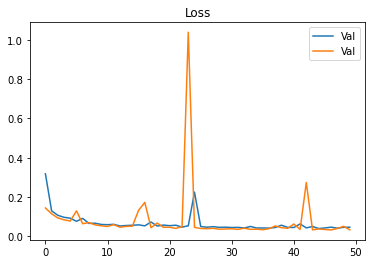

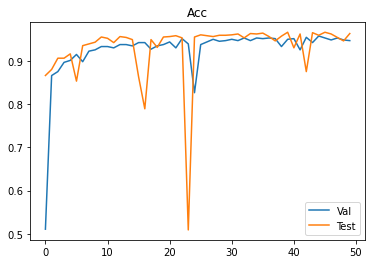

In [12]:
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch.nn import Sequential
import torch
import torch.nn as nn


#显示各层数据的形状
class PrintLayer(nn.Module):
    def __init__(self, name):
        super(PrintLayer, self).__init__()
        self.name = name

    def forward(self, x):
        # Do your print / debug stuff here
        print(f"{self.name} ->{x.shape}")  #print(x.shape)
        return x


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = Sequential(
            nn.Conv2d(3, 2, kernel_size=1, stride=1, bias=True),  #16*3*28*28, 16*2*28*28
            #PrintLayer("Conv2d"),
            nn.BatchNorm2d(2),  #RELU 不如这个
            #PrintLayer("ReLU"),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #PrintLayer("MaxPool2d"),
            nn.Conv2d(2, 3, kernel_size=3, stride=1),
            #PrintLayer("Conv2d"),
            nn.BatchNorm2d(3),  #RELU 不如这个
            #PrintLayer("ReLU"),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #PrintLayer("MaxPool2d")
        )
        self.liner = Sequential(
            nn.Linear(in_features=108, out_features=32, bias=True),
            #PrintLayer("Linear"),
            nn.BatchNorm1d(32),
            nn.Linear(32, 6, bias=True),
            nn.Softmax(dim=1)
        )

    def forward(self, input):
        x = self.model(input)
        x = x.view(x.size(0), -1)
        out = self.liner(x)
        return out


max_epoch = 50
batch_size = 64
lr = 0.1
model = Model()
loss_func = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

train_data, val_data, train_lables, val_lables = train_test_split(train_data, train_lables, test_size=0.1,
                                                                  random_state=42)

train = TensorDataset(torch.FloatTensor(train_data), torch.FloatTensor(train_lables))
dataloader = DataLoader(dataset=train, batch_size=16, shuffle=True)
test_data = torch.FloatTensor(test_data)
test_lables = torch.FloatTensor(test_lables)
val_data = torch.FloatTensor(val_data)
val_lables = torch.FloatTensor(val_lables)
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(max_epoch):
    epoch_loss = []
    epoch_acc = []
    for step, (batch_x, batch_y) in enumerate(dataloader):
        perd = model(batch_x)
        loss = loss_func(perd, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            pred = model(val_data)
            loss = loss_func(pred, val_lables)
            acc = torch.eq(pred.argmax(1), val_lables.argmax(1)).sum() / len(val_lables)
            epoch_acc.append(acc.cpu().data)
            epoch_loss.append(loss.cpu().data)
            print(f"epoch {epoch}-step:{step}: loss={loss.cpu().data}, acc={acc * 100}%")
    train_loss.append(np.mean(epoch_loss))
    train_acc.append(np.mean(epoch_acc))
    pred = model(test_data)
    loss = loss_func(pred, test_lables)
    acc = torch.eq(pred.argmax(1), test_lables.argmax(1)).sum() / len(test_lables)
    test_loss.append(loss.cpu().data)
    test_acc.append(acc.cpu().data)
    print(
        f"\033[0;35mepoch {epoch}: train_loss: {np.mean(epoch_loss):.6f}, test_loss: {loss.cpu().data:.6f}, train_acc={np.mean(epoch_acc) * 100:.6f}%, test_acc={acc * 100:.6f}%\033[0m")

plt.plot([i for i in range(max_epoch)], train_loss)  # training loss
plt.plot([i for i in range(max_epoch)], test_loss)  # validate loss
plt.title("Loss")
plt.legend(["Val", "Val"])
plt.show()

plt.plot([i for i in range(max_epoch)], train_acc)  # training loss
plt.plot([i for i in range(max_epoch)], test_acc)  # validate loss
plt.title("Acc")
plt.legend(["Val", "Test"])
plt.show()